/var/folders/sv/xzgywwf17_d3f25rzb7z7jjh0000gn/T/ipykernel_49590/2641736106.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Count'].fillna(1, inplace=True)
/var/folders/sv/xzgywwf17_d3f25rzb7z7jjh0000gn/T/ipykernel_49590/2641736106.py:69: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowr

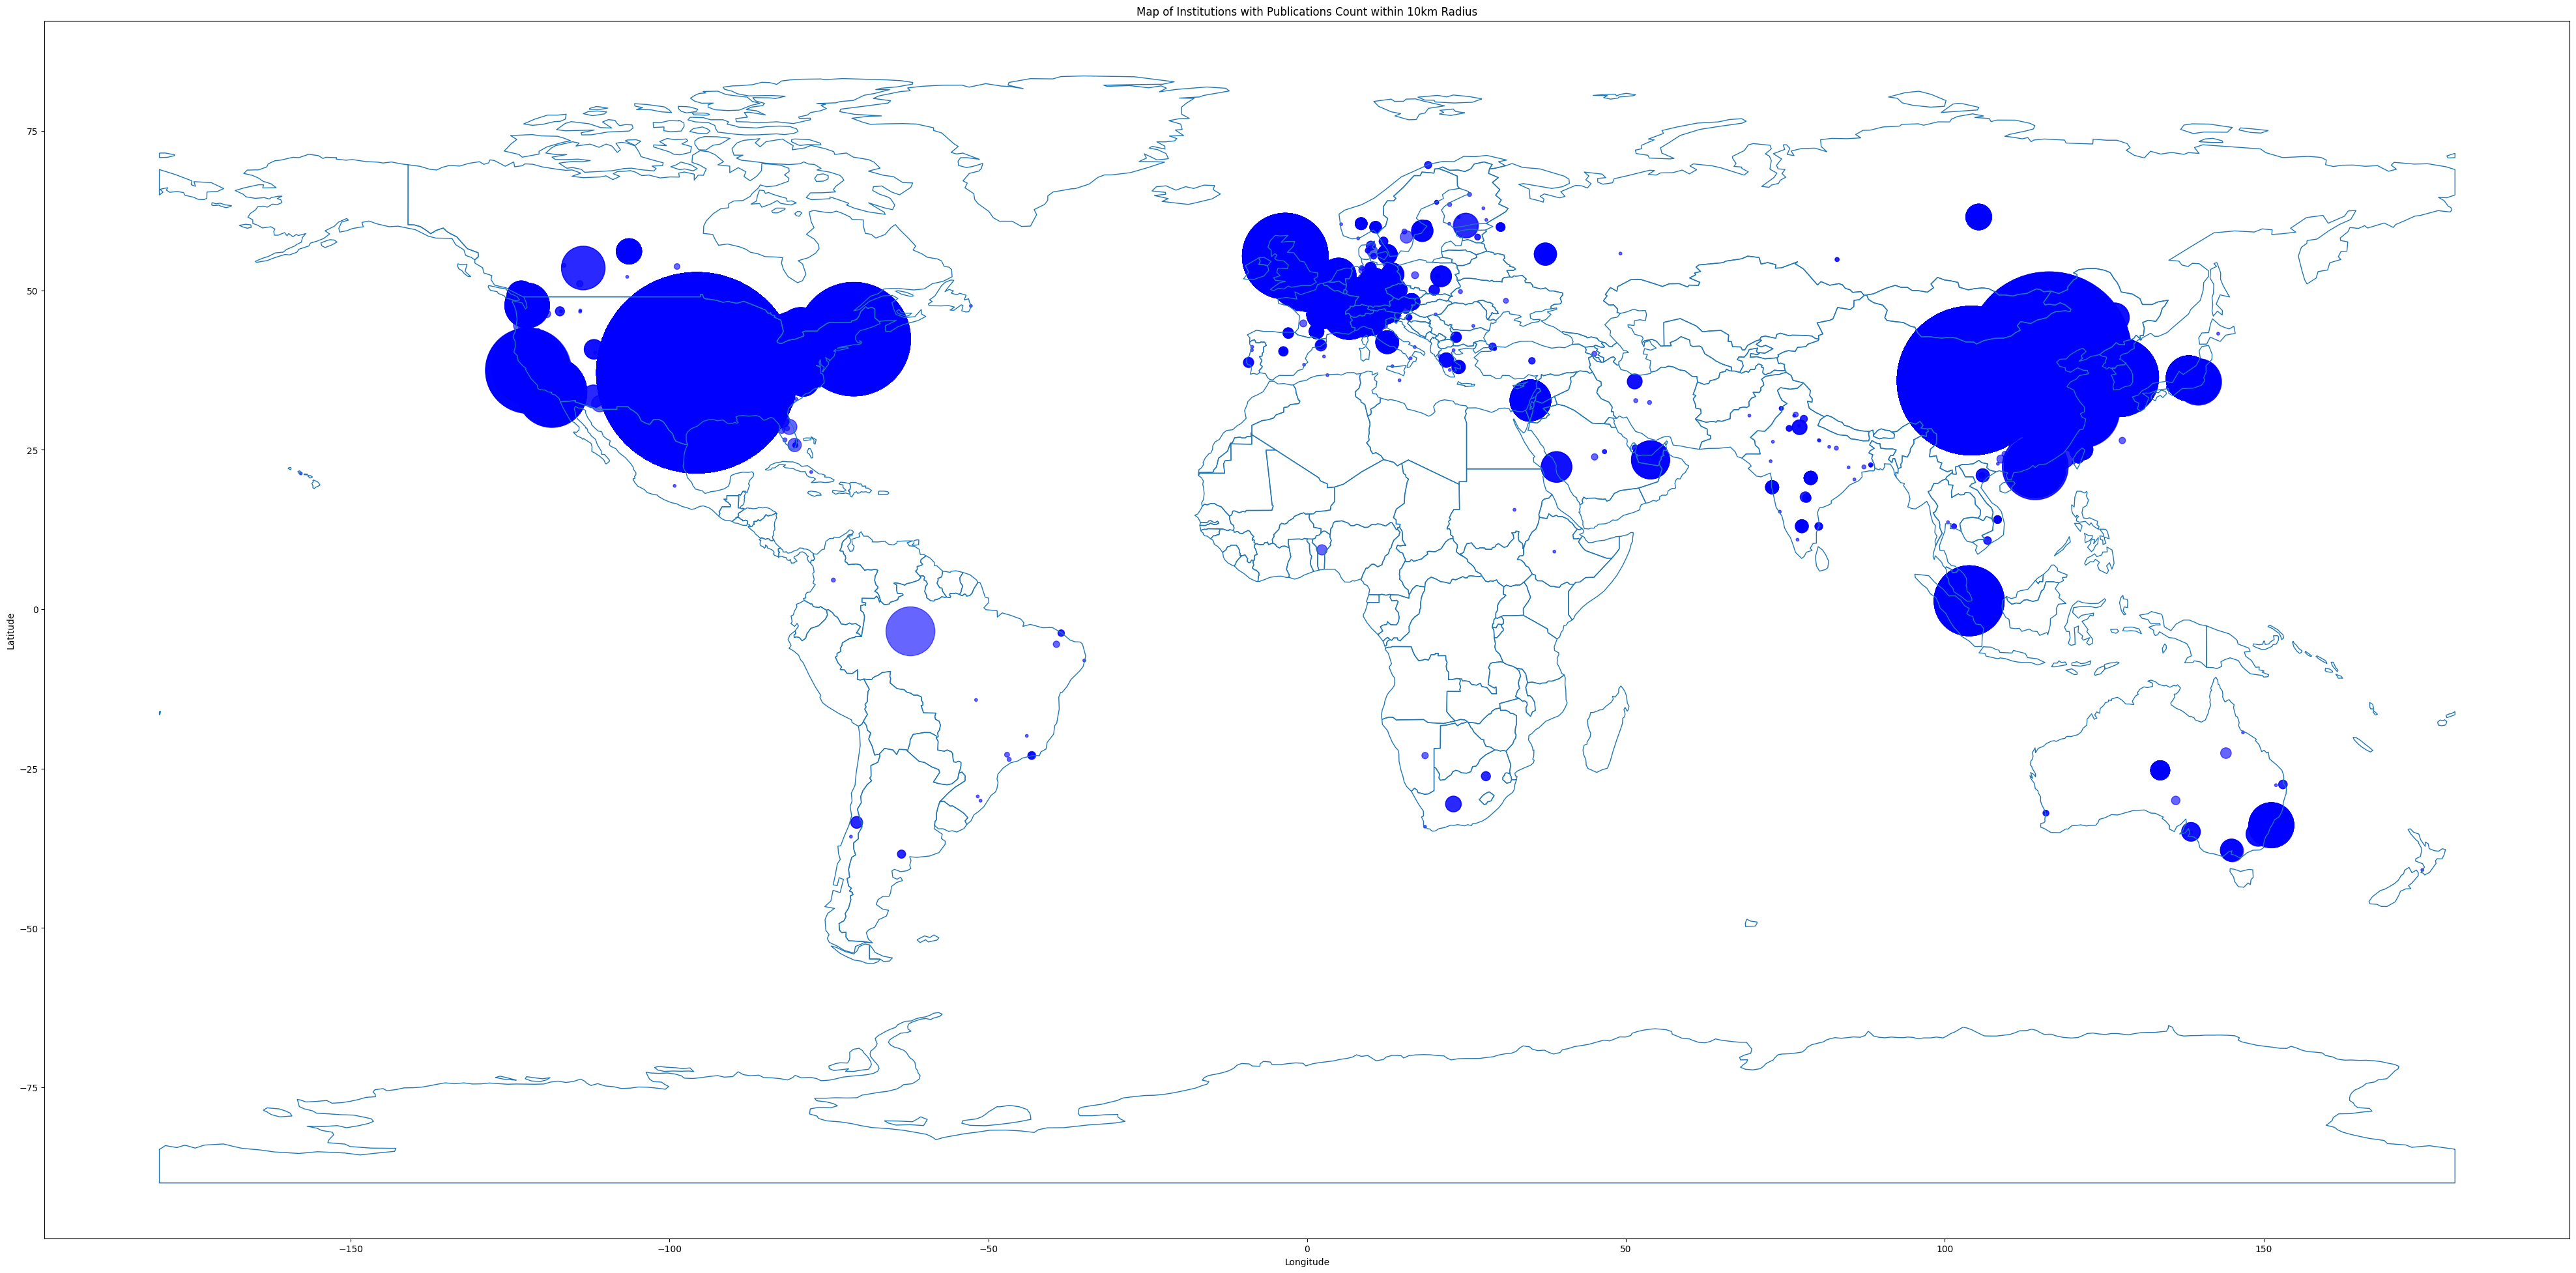

In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopy.distance import geodesic
import json
import os

# Sample data provided
file_path = "affiliations_countries_cleaned_coordinates.csv"

# Create a DataFrame
df = pd.read_csv(file_path)

# Drop rows with missing coordinates
df = df.dropna(subset=["Latitude", "Longitude"])

# Assume 'json_files' is a list of JSON file paths you want to process
json_files = os.listdir('data/')
json_files = [f for f in json_files if f.endswith('.json')]
json_files = ['data/' + f for f in json_files]

# Initialize a dictionary to count affiliation occurrences
affiliation_count = {}

# Loop through the JSON files and count the affiliations
for json_file in json_files:
    with open(json_file, 'r') as f:
        data = json.load(f)
        for paper in data:
            for author in paper['authors']:
                affiliation = author['affiliation'].strip()
                if affiliation:
                    if affiliation in affiliation_count:
                        affiliation_count[affiliation] += 1
                    else:
                        affiliation_count[affiliation] = 1

# Convert the affiliation count dictionary to a DataFrame
affiliation_df = pd.DataFrame(list(affiliation_count.items()), columns=['Affiliation', 'Count'])

# Merge the count data with the original DataFrame
df = df.merge(affiliation_df, how='left', left_on='Institution', right_on='Affiliation')

# Fill missing counts with 1 (assuming an affiliation not in the JSON files should have size 1)
df['Count'].fillna(1, inplace=True)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

# Function to calculate the number of publications within 10km
def count_within_radius(row, gdf, radius_km=10):
    center = (row['Latitude'], row['Longitude'])
    count = 0
    for _, other_row in gdf.iterrows():
        other_point = (other_row['Latitude'], other_row['Longitude'])
        distance = geodesic(center, other_point).kilometers
        if distance <= radius_km:
            count += other_row['Count']
    return count

# Apply the function to count the number of publications within 10km for each location
gdf['Publications_within_10km'] = gdf.apply(lambda row: count_within_radius(row, gdf), axis=1)

/var/folders/sv/xzgywwf17_d3f25rzb7z7jjh0000gn/T/ipykernel_49590/990838649.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


0          3.0
1       1223.0
2       4897.0
3       1559.0
4        253.0
         ...  
2746       2.0
2747       6.0
2748      50.0
2749     325.0
2750     213.0
Name: Publications_within_10km, Length: 2751, dtype: float64


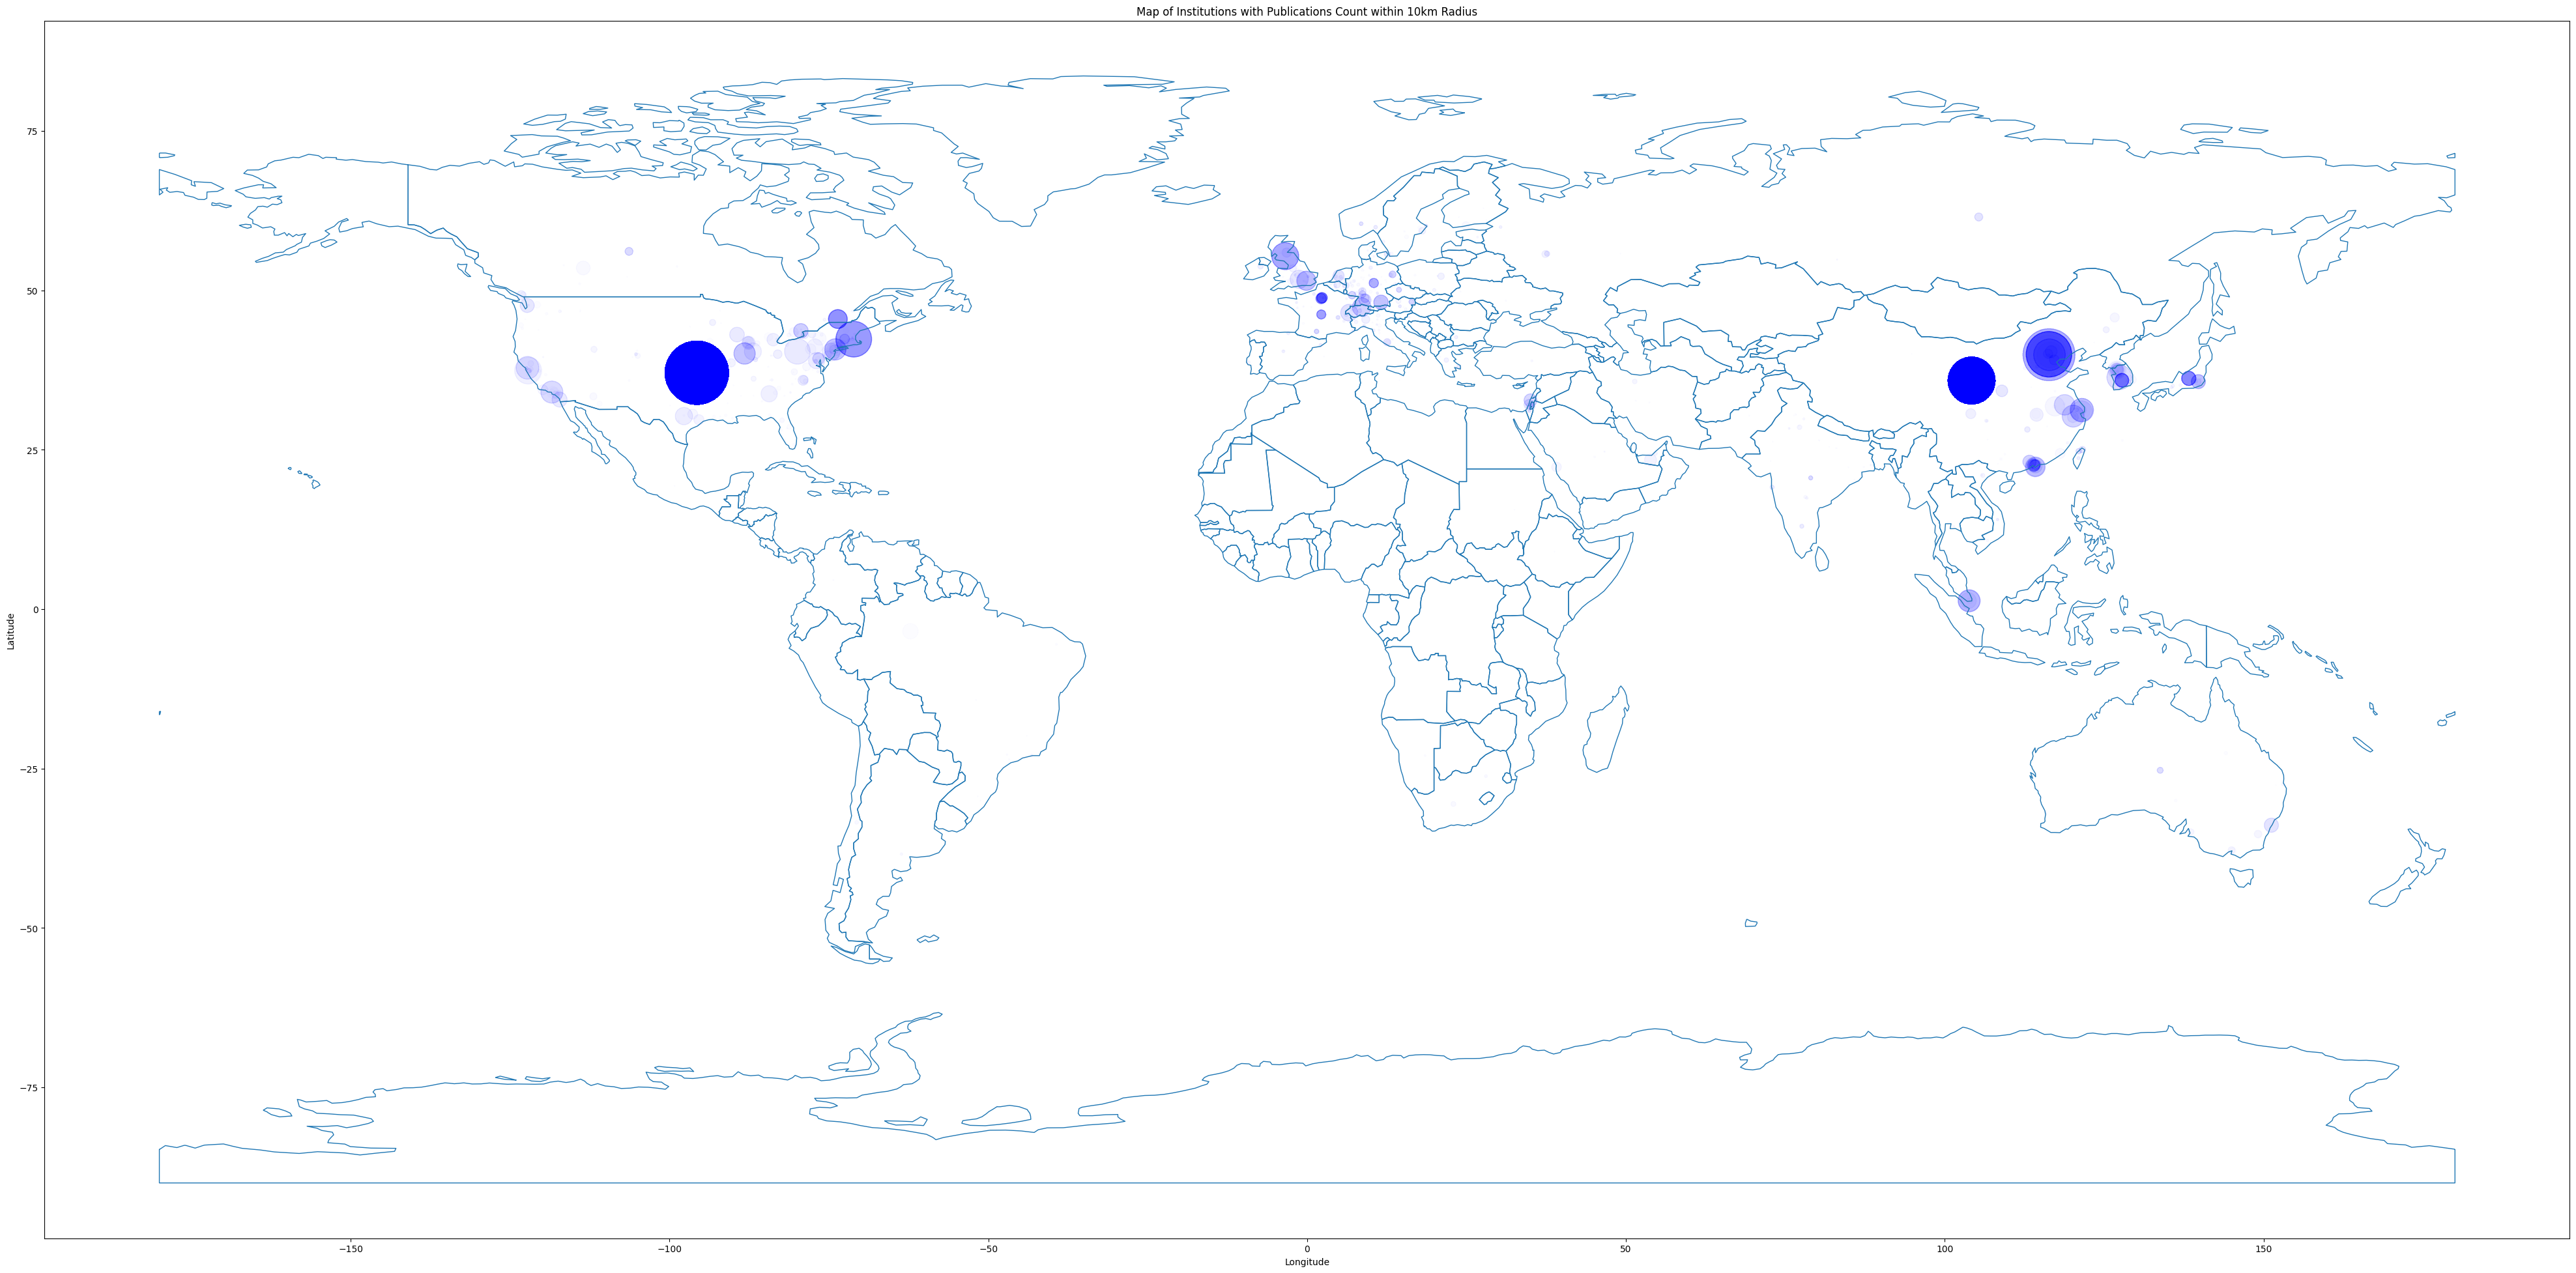

In [8]:
# Plotting the map
fig, ax = plt.subplots(figsize=(50, 30))

# Load a world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the world map
world.boundary.plot(ax=ax, linewidth=1)

# Plot the institutions with marker size proportional to publications within 10 km
gdf.plot(ax=ax, color='blue', markersize=gdf['Publications_within_10km'], alpha=0.01, legend=True)

# Add titles and labels
plt.title('Map of Institutions with Publications Count within 10km Radius')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

In [7]:
print(gdf)

                                            Institution         Country  \
0                                University of Konstanz         Germany   
1                 Samsung R&D Institute China - Beijing           China   
2                                                 Apple             USA   
3                               Harvard Business School   United States   
4                                             TU Munich         Germany   
...                                                 ...             ...   
2746                         Brunel University Uxbridge  United Kingdom   
2747                                              Oosto         Belgium   
2748                   , Hebrew University of Jerusalem          Israel   
2749              University of Maryland - College Park   United States   
2750  Hong Kong University of Science and Technology...           China   

       Latitude   Longitude  \
0     47.689880    9.187944   
1     39.904211  116.407395   
2     